In [39]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os, matplotlib.pyplot as plt
from tensorflow.keras.utils import custom_object_scope
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts


/opt/anaconda3/envs/tfenv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [40]:
IMG_SIZE        = 300
BATCH_SIZE      = 32
EPOCHS_FINE     = 20
MODEL_PATH      = '/Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/classify/finetuned_model(2).h5'  # 原模型
NEW_DATA_DIR    = '/Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/data/blurred_dataset(2)'           # 新数据集目录（结构为train/test）
OUTPUT_PATH     = '/Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/classify/finetuned_model(final).h5'

In [41]:
# 自定义 DepthwiseConv2D 兼容
class DepthwiseConv2DCompat(DepthwiseConv2D):
    def __init__(self, *a, groups=1, **k): super().__init__(*a, **k)

def build_new_dataset():
    def _process(x, y, training=False):
        x = tf.cast(x, tf.float32)
        x = preprocess_input(x)
        return x, y

    raw_train = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(NEW_DATA_DIR, 'train'),
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=True
    )
    raw_val = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(NEW_DATA_DIR, 'test'),
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=False
    )

    class_names = raw_train.class_names
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = raw_train.map(lambda x, y: _process(x, y)).prefetch(AUTOTUNE)
    val_ds   = raw_val.map(lambda x, y: _process(x, y)).prefetch(AUTOTUNE)
    return train_ds, val_ds, class_names


In [42]:
def plot_history(hist):
    acc, val_acc = hist['accuracy'], hist['val_accuracy']
    loss, val_loss = hist['loss'], hist['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(epochs, acc,label='train'); plt.plot(epochs, val_acc,label='val')
    plt.title('Accuracy'); plt.legend()
    plt.subplot(1,2,2); plt.plot(epochs, loss,label='train'); plt.plot(epochs, val_loss,label='val')
    plt.title('Loss'); plt.legend()
    plt.tight_layout(); plt.show()


In [43]:
def fine_tune():
    # 加载数据
    train_ds, val_ds, class_names = build_new_dataset()
    print("新数据类别顺序:", class_names)

    # 加载原模型
    with custom_object_scope({'DepthwiseConv2DCompat': DepthwiseConv2DCompat}):
        model = load_model(MODEL_PATH, compile=False)
    model.trainable = True

    # 冻结 base 中间层，仅微调顶部
    for layer in model.layers[:-25]:
        layer.trainable = False

    # 设置学习率调度器
    lr_schedule = CosineDecayRestarts(
        initial_learning_rate=1e-6,
        first_decay_steps=5,
        t_mul=2.0,          # 每次周期乘2
        m_mul=0.9           # 最低学习率递减
    )

    # 优化器设置
    optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

    # 编译
    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss')
    ]


    # 微调
    history = model.fit(train_ds,
                        validation_data=val_ds,
                        epochs=EPOCHS_FINE,
                        callbacks=callbacks)

    # 保存新模型
    model.save(OUTPUT_PATH)
    print(f"✅ 微调完成，模型已保存为 {OUTPUT_PATH}")

    # 可视化训练过程
    plot_history(history.history)

Found 7631 files belonging to 5 classes.
Found 1067 files belonging to 5 classes.
新数据类别顺序: ['Pallas cats', 'Persian cats', 'Ragdolls', 'Singapura cats', 'Sphynx cats']
Epoch 1/20


2025-07-08 02:26:02.071842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - ETA: 0s - loss: 0.1078 - accuracy: 0.9615

2025-07-08 02:26:59.148987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 68s 266ms/step - loss: 0.1078 - accuracy: 0.9615 - val_loss: 0.1225 - val_accuracy: 0.9578
Epoch 2/20
239/239 [==============================] - 62s 257ms/step - loss: 0.1084 - accuracy: 0.9641 - val_loss: 0.1226 - val_accuracy: 0.9569
Epoch 3/20
239/239 [==============================] - 82s 345ms/step - loss: 0.1029 - accuracy: 0.9642 - val_loss: 0.1223 - val_accuracy: 0.9578
Epoch 4/20
239/239 [==============================] - 75s 312ms/step - loss: 0.0998 - accuracy: 0.9625 - val_loss: 0.1224 - val_accuracy: 0.9578
Epoch 5/20
239/239 [==============================] - 69s 286ms/step - loss: 0.1081 - accuracy: 0.9620 - val_loss: 0.1226 - val_accuracy: 0.9578
Epoch 6/20
239/239 [==============================] - 68s 283ms/step - loss: 0.1060 - accuracy: 0.9607 - val_loss: 0.1225 - val_accuracy: 0.9578


/opt/anaconda3/envs/tfenv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ 微调完成，模型已保存为 /Users/ruiyuhan/Desktop/NUS Deep Learning/SWS3009Assg/classify/finetuned_model(final).h5


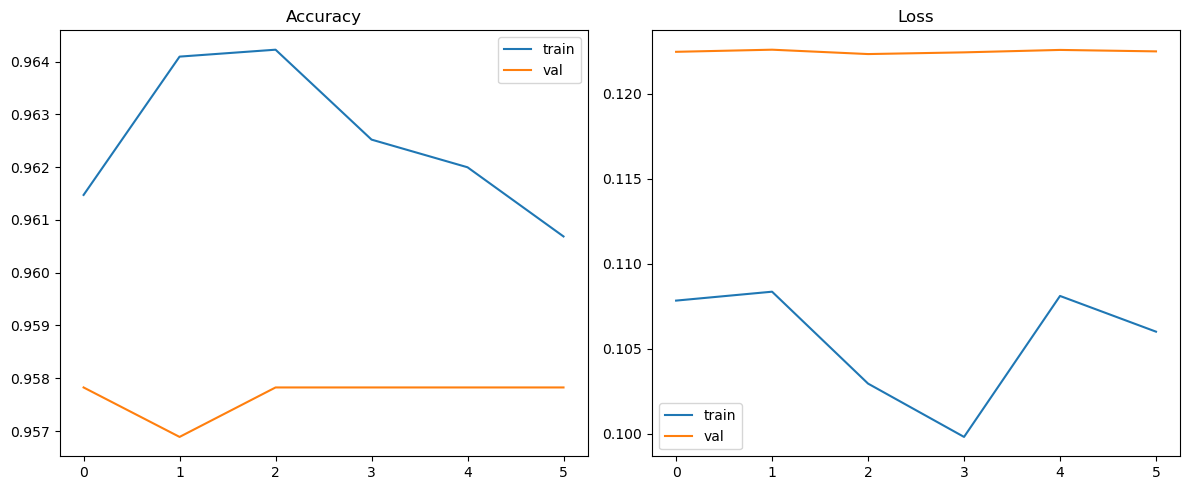

In [44]:
if __name__ == '__main__':
    fine_tune()